# Adult Census Income
## Predict whether income exceeds $50K/yr based on census data.
Source: https://www.kaggle.com/uciml/adult-census-income/home

# 1. Load Python libraries

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 2. Load Dataset

In [2]:
FileName = 'incomedata.csv'
Data = pd.read_csv(FileName)

### Add ID column

In [3]:
Data.insert(0, 'ID', Data.index+1)

# 3. Data Description
### Fields, Data Types, Bastic Statistics

In [4]:
DataStats = Data.describe(include='all').transpose()
DataStats['DataType'] = Data.dtypes
DataStats

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,DataType
ID,32561,NaN,NaN,NaN,16281,9399.7,1,8141,16281,24421,32561,int64
age,32561,NaN,NaN,NaN,38.5816,13.6404,17,28,37,48,90,int64
workclass,32561,9,Private,22696,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object
fnlwgt,32561,NaN,NaN,NaN,189778,105550,12285,117827,178356,237051,1.48470e+06,int64
education,32561,16,HS-grad,10501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object
education-num,32561,NaN,NaN,NaN,10.0807,2.57272,1,9,10,12,16,int64
marital-status,32561,7,Married-civ-spouse,14976,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object
occupation,32561,15,Prof-specialty,4140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object
relationship,32561,6,Husband,13193,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object
race,32561,5,White,27816,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object


# 4. Prepare dataset for modeling

## Inspect Categorical Variables

In [5]:
Data.workclass.unique()

array(['?', 'Private', 'State-gov', 'Federal-gov', 'Self-emp-not-inc',
       'Self-emp-inc', 'Local-gov', 'Without-pay', 'Never-worked'],
      dtype=object)

In [6]:
Data.education.unique()

array(['HS-grad', 'Some-college', '7th-8th', '10th', 'Doctorate',
       'Prof-school', 'Bachelors', 'Masters', '11th', 'Assoc-acdm',
       'Assoc-voc', '1st-4th', '5th-6th', '12th', '9th', 'Preschool'],
      dtype=object)

In [7]:
Data.occupation.unique()

array(['?', 'Exec-managerial', 'Machine-op-inspct', 'Prof-specialty',
       'Other-service', 'Adm-clerical', 'Craft-repair',
       'Transport-moving', 'Handlers-cleaners', 'Sales',
       'Farming-fishing', 'Tech-support', 'Protective-serv',
       'Armed-Forces', 'Priv-house-serv'], dtype=object)

## Create Categorical Variables from continious variables

In [8]:
AgeLabels = ['<20', '20-30', '30-40', '40-50', '50-60', '>60']
AgeLabelsBins = [0, 20, 30, 40, 50, 60, np.inf]
Data['AgeRange'] = pd.cut(Data.age, bins=AgeLabelsBins, labels=AgeLabels)

In [9]:
HoursPerWeekLabels = ['<20', '20-40', '40-50', '50-60', '>60']
HoursPerWeekLabelsBins = [0, 20, 40, 50, 60, np.inf]
Data['HoursPerWeekRange'] = pd.cut(Data['hours-per-week'], bins=HoursPerWeekLabelsBins, labels=HoursPerWeekLabels)

In [10]:
EducationNumLabels = ['<5', '5-10', '10-15', '>15']
EducationNumBins = [0, 5, 10, 15, np.inf]
Data['EducationNumRange'] = pd.cut(Data['education-num'], bins=EducationNumBins, labels=EducationNumLabels)

In [11]:
FNLWGTLabels = ['<15k', '15k-100k', '100k-200k', '200k-300k','>300k']
FNLWGTBins = [0, 15000, 100000, 200000, 300000, np.inf]
Data['FNLWGTRange'] = pd.cut(Data['fnlwgt'], bins=FNLWGTBins, labels=FNLWGTLabels)

## Identify Predictor variables (X) and Response variable (y)

In [12]:
Data.columns

Index(['ID', 'age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income', 'AgeRange', 'HoursPerWeekRange', 'EducationNumRange',
       'FNLWGTRange'],
      dtype='object')

In [13]:
Variables = ['workclass', 'FNLWGTRange', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'AgeRange', 'HoursPerWeekRange', 'EducationNumRange', 'native-country']
Response = 'income'

## Create Modeling dataset

In [14]:
VariablesDummies = pd.get_dummies(Data[Variables]) 
VariablesDummies['CapitalGain'] = np.where(Data['capital-gain']>0,1,0) 
VariablesDummies['CapitalLoss'] = np.where(Data['capital-loss']>0,1,0) 
PredictorVariables = VariablesDummies.columns

Data[PredictorVariables] = VariablesDummies
Data['Response'] = np.where(Data[Response]=='>50K',1,0)
Data.sample(5)

,ID,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,...,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,CapitalGain,CapitalLoss,Response
13142,13143,28,Private,394927,Some-college,10,Married-civ-spouse,Tech-support,Husband,White,...,0,0,0,0,1,0,0,0,0,1
23867,23868,45,Private,165484,Doctorate,16,Married-civ-spouse,Prof-specialty,Husband,White,...,0,0,0,0,1,0,0,0,0,1
327,328,35,Private,187119,Bachelors,13,Divorced,Sales,Not-in-family,White,...,0,0,0,0,1,0,0,0,1,0
26880,26881,38,Private,185203,HS-grad,9,Widowed,Other-service,Unmarried,White,...,0,0,0,0,1,0,0,0,0,0
27653,27654,51,Private,142835,11th,7,Married-civ-spouse,Machine-op-inspct,Husband,White,...,0,0,0,0,1,0,0,0,0,0


## Split data to train and test datasets

In [15]:
DataTrain, DataTest = train_test_split(Data, test_size=0.3, random_state=42)

In [16]:
X_train = DataTrain[PredictorVariables]
X_test = DataTest[PredictorVariables]
y_train = DataTrain['Response']
y_test = DataTest['Response']

# 5. Run classifier algorithms

## Create classifiers

In [17]:
# Create classifiers
LGR = LogisticRegression()
RFC = RandomForestClassifier(n_estimators=50)

### Logistic Regression (LGR)

In [18]:
LGR.fit(X_train, y_train)
prob_pos_LGR = LGR.predict_proba(X_test)[:, 1]
DataTest['Probability_LGR'] = LGR.predict_proba(X_test)[:, 1]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Random Forest Classifier (RFC)

In [19]:
RFC.fit(X_train, y_train)
prob_pos_RFC = RFC.predict_proba(X_test)[:, 1]
DataTest['Probability_RFC'] = RFC.predict_proba(X_test)[:, 1]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


# 6. Evaluate Model Performance

##  Claibration Curves

In [20]:
fraction_of_positives_LGR, mean_predicted_value_LGR = calibration_curve(y_test, DataTest['Probability_LGR'], n_bins=10)
fraction_of_positives_RFC, mean_predicted_value_RFC = calibration_curve(y_test, DataTest['Probability_RFC'], n_bins=10)

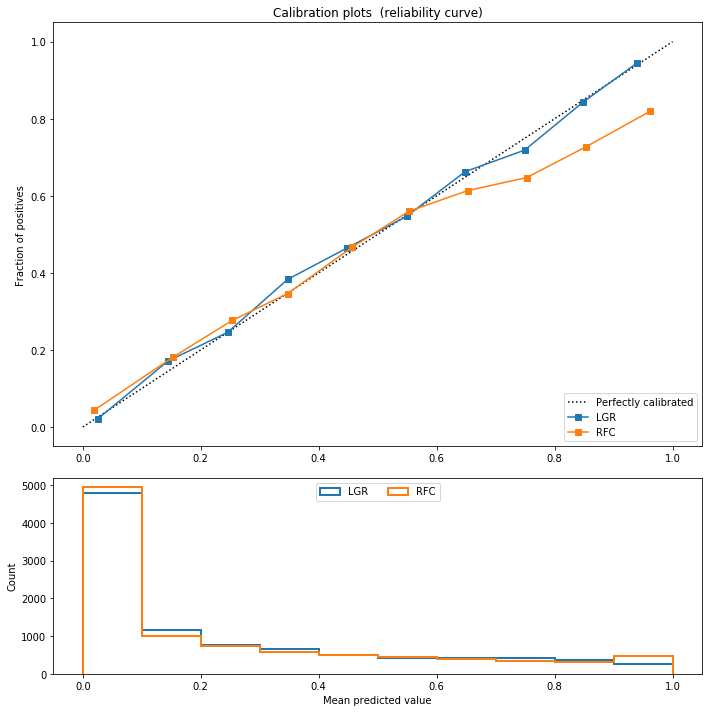

In [21]:
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))
ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

ax1.plot(mean_predicted_value_LGR, fraction_of_positives_LGR, "s-", label="%s" % ('LGR', ))
ax1.plot(mean_predicted_value_RFC, fraction_of_positives_RFC, "s-", label="%s" % ('RFC', ))

ax2.hist(DataTest['Probability_LGR'], range=(0, 1), bins=10, label='LGR', histtype="step", lw=2)
ax2.hist(DataTest['Probability_RFC'], range=(0, 1), bins=10, label='RFC', histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()

## ROC Curve
### True Positive Rate (TPR) vs.False Positive Rate (FPR)
#### References
* T. Fawcett, An introduction to ROC analysis, Pattern Recognition Letters, Volume 27, Issue 8, June 2006, Pages 861-874. doi.org/10.1016/j.patrec.2005.10.010. 
* sklearn.metrics.roc_curve, http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html

In [22]:
FPR_LGR, TPR_LGR, _ = roc_curve(y_test, prob_pos_LGR)
FPR_RFC, TPR_RFC, _ = roc_curve(y_test, prob_pos_RFC)

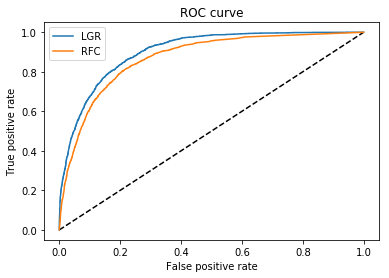

In [23]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(FPR_LGR, TPR_LGR, label='LGR')
plt.plot(FPR_RFC, TPR_RFC, label='RFC')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Generate Predicted Value (Score)

In [24]:
DataTest['Predicted_LGR'] = np.where(DataTest['Probability_LGR']>0.4,1,0)
DataTest['Predicted_RFC'] = np.where(DataTest['Probability_RFC']>0.4,1,0)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Confusion Matrix
### CF[actual, predicted]

In [25]:
def ConfusionMatrix(ActualColumn, PredictedColumn, labels=None, sample_weight=None, Totals=False):
    from sklearn.metrics import confusion_matrix
    CF = confusion_matrix(ActualColumn,PredictedColumn, labels=labels)
    CF = pd.DataFrame(data=CF)
    
    if Totals==True:
        CF[2] = CF.sum(axis=1)
        CF.loc[2] = CF.sum(axis=0)  
        TotalsLabel= [['Total'], ['']]
    else:
        TotalsLabel= [[],[]]

    ColNames = [['Predicted']*len(labels)+TotalsLabel[0], labels+TotalsLabel[1]]
    RowNames = [['Actual']*len(labels)+TotalsLabel[0], labels+TotalsLabel[1]]
    columns = pd.MultiIndex.from_arrays(ColNames)
    index = pd.MultiIndex.from_arrays(RowNames)    
    CF.index = index
    CF.columns=columns
    
    return CF

In [26]:
CF_LGR = ConfusionMatrix(DataTest['Response'], DataTest['Predicted_LGR'], labels=[0,1], Totals=True)
CF_LGR

Predicted       Total
                 0     1      
Actual 0      6640   789  7429
       1       739  1601  2340
Total         7379  2390  9769

In [27]:
CF_RFC = ConfusionMatrix(DataTest['Response'], DataTest['Predicted_RFC'], labels=[0,1], Totals=True)
CF_RFC

Predicted       Total
                 0     1      
Actual 0      6518   911  7429
       1       781  1559  2340
Total         7299  2470  9769

### Confusion Matrix Terms
#### For a Binary Classifier
* TN= CF[0,0], FP= CF[0,1], FN= CF[1,0], TP= CF[1,1]
* Accuracy (ACC) = (TP+TN)/TOTAL
* Hit Rate, Sensitivity, Recall or True Positive Rate (TPR) = TP/(TP+FN)
* False Positive Rate (FPR) = FP/(FP+TN) 
* Specificity or True Negative Rate (TNR) = TN/(FP+TN)
* Miss Rate or False Negative rate (FNR) = FN/(FN+TP) 
* Positive Predictive Value or Precision (PPV) = TP/(TP+FP) 
* Harmonic Mean of Precision and Sensitivity or F1 score (F1) = 2TP/(2TP+FP+FN)

#### For a Multi-class Classifier
* TPS = Diagonal(CF)
* SUCCESS = Sum(TPS)
* Sum of Actual Conditions (ASUM) = RowSum(CF)
* Sum of Predicted conditions (PSUM) = ColumnsSum(CF)
* Positive Predictive Value or Precision for Class i (PPV[i]) = TPS[i]/PSUM
* Hit Rate, Sensitivity, Recall or True Positive Rate for Class i (TPR[i]) = TPS[i]/ASUM

##### References: 
* C. Beleites, R. Salzer, V. Sergo, Validation of soft classification models using partial class memberships: An extended concept of sensitivity & co. applied to grading of astrocytoma tissues, Chemometrics and Intelligent Laboratory Systems Volume 122, 15 March 2013, Pages 12-22. doi.org/10.1016/j.chemolab.2012.12.003.
* sklearn.metrics.confusion_matrix, http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
* Confusion Matrix, http://www2.cs.uregina.ca/~dbd/cs831/notes/ROC/ROC.html.




In [28]:
def ConfusionMatrixTerms(CF, ModelID='M'):     
    if CF.columns.values[-1][0]=='Total':        
        Labels= CF.columns.levels[1].values[:-1]
        CF= CF.values[:-1,:-1]
    else:
        Labels= CF.columns.levels[1].values
        CF= CF.values
        
    if len(CF)==2:
        # Compute confusion matrix
        TN = CF[0,0]
        FP = CF[0,1]
        FN = CF[1,0]
        TP = CF[1,1]
        TOTAL = TN+FP+FN+TP   

        CFTERMS = pd.DataFrame(data=[[TN, FP, FN, TP, TOTAL]], columns=['TN', 'FP', 'FN', 'TP', 'TOTAL'])
        CFTERMS.insert(0, 'ModelID', ModelID)

        CFTERMS['P1'] = FP+TP
        CFTERMS['P0'] = TN+FN
        CFTERMS['A1'] = TP+FN
        CFTERMS['A0'] = FP+TN

        CFTERMS['TPR'] = TP/(TP+FN) #TP/A1
        CFTERMS['TNR'] = TN/(FP+TN) #TN/A0
        CFTERMS['FPR'] = FP/(FP+TN) #FP/A0    
        CFTERMS['FNR'] = FN/(FN+TP) #FN/A1

        CFTERMS['PPV'] = TP/(TP+FP) #TP/P1W
        CFTERMS['ACC'] = (TP+TN)/TOTAL
        CFTERMS['F1'] = 2*TP/(2*TP+FP+FN)
        
    else:  
        TOTAL = np.sum(CF)
        TPS = np.diagonal(CF)
        SUCCESS = np.sum(TPS) #np.trace(CF)
        
        ASUM = np.sum(CF,axis=1) #Sum of Actual Conditions
        PSUM = np.sum(CF,axis=0) #Sum of Predicted conditions
        PPV = TPS/PSUM
        TPR = TPS/ASUM
               
        CFTERMS = pd.DataFrame(data=[[ModelID, TOTAL, SUCCESS]], columns=['ModelID', 'TOTAL', 'SUCCESS'])
        CFTERMS['ACC'] = SUCCESS/TOTAL  
        for i in range(len(Labels)):
            label = str(Labels[i])
            CFTERMS[label+'_PPV']=PPV[i]
            CFTERMS[label+'_TPR']=TPR[i]
            
    return CFTERMS

In [29]:
CFTERMS= ConfusionMatrixTerms(CF_LGR, ModelID='LGR')
CFTERMS.append(ConfusionMatrixTerms(CF_RFC, ModelID='RFC'),ignore_index=True)

,ModelID,TN,FP,FN,TP,TOTAL,P1,P0,A1,A0,TPR,TNR,FPR,FNR,PPV,ACC,F1
0,LGR,6640,789,739,1601,9769,2390,7379,2340,7429,0.684188,0.893795,0.106205,0.315812,0.669874,0.843587,0.676956
1,RFC,6518,911,781,1559,9769,2470,7299,2340,7429,0.666239,0.877372,0.122628,0.333761,0.631174,0.826799,0.648233
